# 1. 필요한 라이브러리 import

In [1]:
import os
import fnmatch
from collections import Counter
import zipfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 2. 데이터 준비


- 데이터 병합

In [ ]:
# import os
# import shutil

# # 병합할 두 폴더 경로
# video_folders = ['./SVideo2','./SVideo3']  # 이미 압축 해제된 폴더들
# target_folder_path = './SVideo1'     # 최종 병합할 위치

# os.makedirs(target_folder_path, exist_ok=True)

# # 두 폴더 순회하면서 파일 병합
# for video_folder_path in video_folders:
#     for root, _, files in os.walk(video_folder_path):
#         for file in files:
#             source_file_path = os.path.join(root, file)
#             target_file_path = os.path.join(target_folder_path, file)

#             # 중복될 경우 파일명 뒤에 번호 붙이기
#             if os.path.exists(target_file_path):
#                 base, extension = os.path.splitext(file)
#                 counter = 1
#                 new_file_name = f"{base}_{counter}{extension}"
#                 new_target_file_path = os.path.join(target_folder_path, new_file_name)
#                 while os.path.exists(new_target_file_path):
#                     counter += 1
#                     new_file_name = f"{base}_{counter}{extension}"
#                     new_target_file_path = os.path.join(target_folder_path, new_file_name)
#                 target_file_path = new_target_file_path

#             shutil.move(source_file_path, target_file_path)

# print("Video1과 Video2 폴더 병합이 완료되었습니다.")

Video1과 Video2 폴더 병합이 완료되었습니다.


- 손상된 이미지 삭제

In [2]:
folder_path = './SVideo'

# 폴더 내의 모든 파일을 순회
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 형식을 여기에 추가
        try:
            img = Image.open(os.path.join(folder_path, filename))  # 이미지 열기 시도
            img.verify()  # 이미지가 손상되었는지 확인
        except (IOError, SyntaxError) as e:
            print(f'{filename} is corrupted and will be deleted.')  # 손상된 이미지 파일명 출력
            os.remove(os.path.join(folder_path, filename))  # 손상된 이미지 삭제


# 3. 데이터의 분포 확인
- go/right/left/stop 별 이미지 데이터의 개수 확인
    - index: 090 ➡️ go
    - index: 135 ➡️ right
    - index: 045 ➡️ left
    - index: 180 ➡️ stop

In [3]:
folder_path = './SVideo'

# 이미지 파일 인덱스 집계를 위한 빈 Counter 객체 생성
index_counter = Counter()

# 삭제된 이미지를 제외한 폴더 내의 모든 파일을 순회
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 형식을 여기에 추가
        index = filename[7:10]  # 파일명에서 인덱스 추출
            
        index_counter[index] += 1  # 추출된 인덱스에 대한 카운트 증가

# 인덱스별 이미지 개수 출력
for index, count in index_counter.items():
    print(f'Index: {index}, Count: {count}')

Index: 180, Count: 324
Index: 090, Count: 184
Index: 045, Count: 191


# 4. 데이터를 변수에 저장
- stop데이터 ➡️ stopline = 1으로 라벨링
- go/right/left데이터 ➡️ stopline = 0으로 라벨링

image_path: ./SVideo\_00020_180.png
steering_Angle: 1


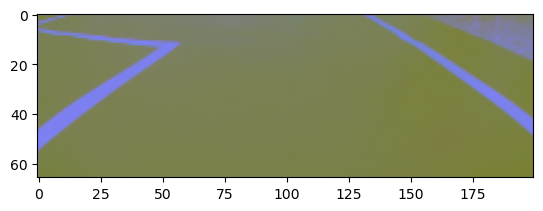

In [4]:
data_dir = './SVideo'
file_list = os.listdir(data_dir)
image_paths = [] # 이미지 경로를 저장하는 변수
stopline_yesno = [] # 이미지 각도를 저장하는 변수
pattern = "*.png" # .png 확장자 가진 파일만 취급

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        file_path = os.path.join(data_dir, filename)
        try:
            # 이미지 파일을 열어보려고 시도
            with Image.open(file_path) as img:
                # 파일이 성공적으로 열렸다면 리스트에 추가
                image_paths.append(file_path)
                if filename[7:10]=='180':
                    stopline = 1
                else:
                    stopline = 0
                stopline_yesno.append(stopline)
        except:
            # 파일 열기에 실패한 경우, 예외가 발생하고 해당 파일은 무시
            print(f"Failed to open {file_path}")


# 이후 과정은 동일하게 진행
image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("steering_Angle: %d" % stopline_yesno[image_index])

df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Stopline'] = stopline_yesno

- stop과 non-stop 데이터의 분포 확인 

In [5]:
# 데이터프레임 생성
df = pd.DataFrame({
    'ImagePath': image_paths,
    'Stopline': stopline_yesno
})

# stopline 값에 따른 분포 확인
distribution = df['Stopline'].value_counts()

print(distribution)


Stopline
0    375
1    324
Name: count, dtype: int64


# 5. 전처리 & 데이터 분리 & 모델 선언 & 모델 학습 & 평가 & 저장

In [6]:
import os
import fnmatch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 이미지 로딩 및 전처리
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((200, 66))  # (width, height) 순서
    img = img_to_array(img)
    img /= 255.0  # Normalize the image
    return img

images = np.array([preprocess_image(path) for path in df['ImagePath']])
labels = np.array(df['Stopline'])

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 라벨 원-핫 인코딩
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# 모바일넷 모델 로드 및 수정
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(66, 200, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 기존 층을 학습하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False
    

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# 모델 학습
batch_size = 32
epochs = 50

model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(X_train) // batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 모델 저장
model.save('./stopline_model.h5')
print("Model saved to stopline_model.h5")




Epoch 1/50


17/17 [==============================] - 8s 248ms/step - loss: 0.6994 - accuracy: 0.8425 - val_loss: 0.2116 - val_accuracy: 0.9500
Epoch 2/50
17/17 [==============================] - 3s 185ms/step - loss: 0.4809 - accuracy: 0.8824 - val_loss: 0.1860 - val_accuracy: 0.9500
Epoch 3/50
17/17 [==============================] - 3s 187ms/step - loss: 0.1712 - accuracy: 0.9355 - val_loss: 0.1542 - val_accuracy: 0.9143
Epoch 4/50
17/17 [==============================] - 3s 192ms/step - loss: 0.1827 - accuracy: 0.9279 - val_loss: 0.0889 - val_accuracy: 0.9571
Epoch 5/50
17/17 [==============================] - 3s 196ms/step - loss: 0.1984 - accuracy: 0.9260 - val_loss: 0.1869 - val_accuracy: 0.9000
Epoch 6/50
17/17 [==============================] - 4s 202ms/step - loss: 0.1231 - accuracy: 0.9583 - val_loss: 0.1472 - val_accuracy: 0.9143
Epoch 7/50
17/17 [==============================] - 3s 200ms/step - loss: 0.1434 - accuracy: 0.9469 - val_loss: 0.1718 - val_accuracy: 0.9143
E

d:\pythontemp\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to stopline_model.h5


# 6. 데이터 예측 시각화

1/1 [==============================] - 1s 652ms/step


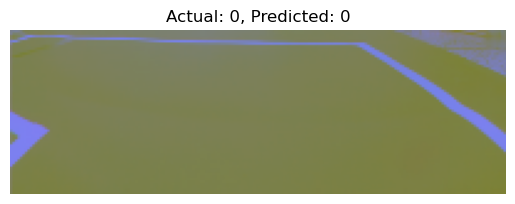

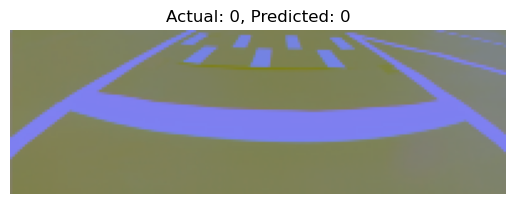

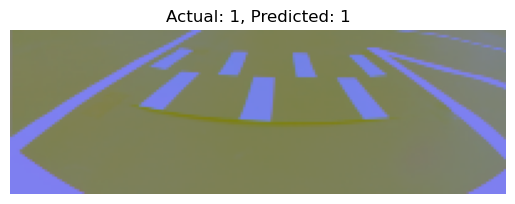

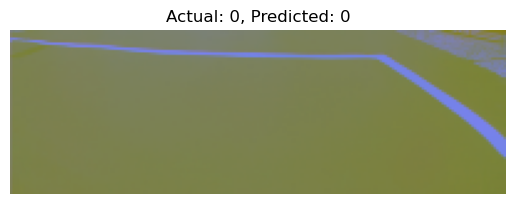

In [8]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 모델 로드
model = tf.keras.models.load_model('./stopline_model.h5')

# 예시 이미지 4개에 대한 실제 값과 예측값 보여주기
example_indices = np.random.choice(len(df), 4, replace=False)
example_images = [preprocess_image(df['ImagePath'].iloc[idx]) for idx in example_indices]
example_images_array = np.array(example_images)
example_labels = df['Stopline'].iloc[example_indices].values

# 예측 수행
predicted_labels = model.predict(example_images_array)

# 실제 값과 예측값 출력
for i in range(4):
    plt.figure()
    img = Image.open(df['ImagePath'].iloc[example_indices[i]])
    img = img.resize((200, 66))  # Resize to match the model's input size
    plt.imshow(img)
    # 원-핫 인코딩된 예측값에서 가장 높은 확률을 가진 인덱스 선택
    predicted_label = np.argmax(predicted_labels[i])
    plt.title(f"Actual: {example_labels[i]}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
